Import packages

In [1]:
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
from matplotlib import pyplot as plt



Using Theano backend.


Define the parameters:

In [3]:
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
epoch = 1000
hidden_size = 100
batch_size = 50
grid_size = 10
max_memory = 100
discount = 0.9
memory = list()
Loss = np.array([])
Win_cnt = np.array([])

Make the neural network

In [4]:
model1 = Sequential()
model1.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model1.add(Dense(num_actions))
model1.compile(sgd(lr=.2), "mse")

model2 = Sequential()
model2.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model2.add(Dense(hidden_size, activation='relu'))
model2.add(Dense(num_actions))
model2.compile(sgd(lr=.2), "mse")

model3 = Sequential()
model3.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model3.add(Dense(hidden_size, activation='relu'))
model3.add(Dense(hidden_size, activation='relu'))
model3.add(Dense(num_actions))
model3.compile(sgd(lr=.2), "mse")


Dfine the Action function:

In [5]:
def Action(action,state):
    if action == 0:  # left
        action = -1
    elif action == 1:  # stay
        action = 0
    else:
        action = 1  # right
    f0, f1, basket = state#[0]
    new_basket = min(max(1, basket + action), grid_size-1)
    f0 += 1
    out = np.asarray([f0, f1, new_basket])
    out = out[np.newaxis]
    assert len(out.shape) == 2
    state = out
    
    if f0 == grid_size-1:
        if abs(f1 - basket) <= 1:
            reward = 1
        else:
            reward = -1
    else:
        reward = 0
        
    if state[0, 0] == grid_size-1:
        game_over = True
    else:
        game_over = False
        
        
    im_size = (grid_size,)*2
    state = state[0]
    canvas = np.zeros(im_size)
    canvas[state[0], state[1]] = 1  # draw fruit
    canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
    canvas=canvas.transpose()

    return state, canvas.reshape((1, -1)), reward, game_over

Define the Memory function to append the states in Memory and relocate it if it is full:

In [6]:
def Memory(states, game_over):
    # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
    memory.append([states, game_over])
    if len(memory) > max_memory:
        del memory[0]

Batch function:

In [7]:
def Batch(model, batch_size):
    len_memory = len(memory)
    num_actions = model.output_shape[-1]
    env_dim = memory[0][0][0].shape[1]
    inputs = np.zeros((min(len_memory, batch_size), env_dim))
    targets = np.zeros((inputs.shape[0], num_actions))
    for i, idx in enumerate(np.random.randint(0, len_memory,
                                              size=inputs.shape[0])):
        state_t, action_t, reward_t, state_tp1 = memory[idx][0]
        game_over = memory[idx][1]

        inputs[i:i+1] = state_t
        # There should be no target values for actions not taken.
        # Thou shalt not correct actions not taken #deep
        targets[i] = model.predict(state_t)[0]
        Q_sa = np.max(model.predict(state_tp1)[0])
        if game_over:  # if game_over is True
            targets[i, action_t] = reward_t
        else:
            # reward_t + gamma * max_a' Q(s', a')
            targets[i, action_t] = reward_t + discount * Q_sa
    return inputs, targets

Traning:

In [8]:
def Train(model):
    Loss = np.array([])
    Win_cnt = np.array([])
    win_cnt = 0
    for e in range(epoch):
        loss = 0.
        n = np.random.randint(0, grid_size-1, size=1)
        m = np.random.randint(1, grid_size-2, size=1)
        state = np.asarray([0, n, m])[np.newaxis]
        game_over = False

        im_size = (grid_size,)*2
        state = state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        canvas=canvas.transpose()

        input_t = canvas.reshape((1, -1))
        while not game_over:
            input_tm1 = input_t
            # get next action
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)
            else:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])
            state, input_t, reward, game_over = Action(action,state)
            if reward == 1:
                win_cnt += 1

            Memory([input_tm1, action, reward, input_t], game_over)

            # adapt model
            inputs, targets = Batch(model, batch_size=batch_size)

            loss += model.train_on_batch(inputs, targets)
        Win_cnt = np.append(Win_cnt,win_cnt)
        Loss=np.append(Loss,loss)
        print("Epoch {:03d}/{} | Loss {:.4f} | Win count {}".format((e+1), epoch, loss, win_cnt))
    return Loss, Win_cnt
    

In [2]:
print('model1:')
Loss1, Win_cnt1 = Train(model1)
model1.save_weights("model1.h5", overwrite=True)
with open("model1.json", "w") as outfile:
    json.dump(model1.to_json(), outfile)
print('model2:')
Loss2, Win_cnt2 = Train(model2)
model2.save_weights("model2.h5", overwrite=True)
with open("model2.json", "w") as outfile:
    json.dump(model2.to_json(), outfile)
print('model3:')
Loss3, Win_cnt3 = Train(model3)
model3.save_weights("model3.h5", overwrite=True)
with open("model3.json", "w") as outfile:
    json.dump(model3.to_json(), outfile)

model1:


NameError: name 'Train' is not defined

In [9]:
%matplotlib inline

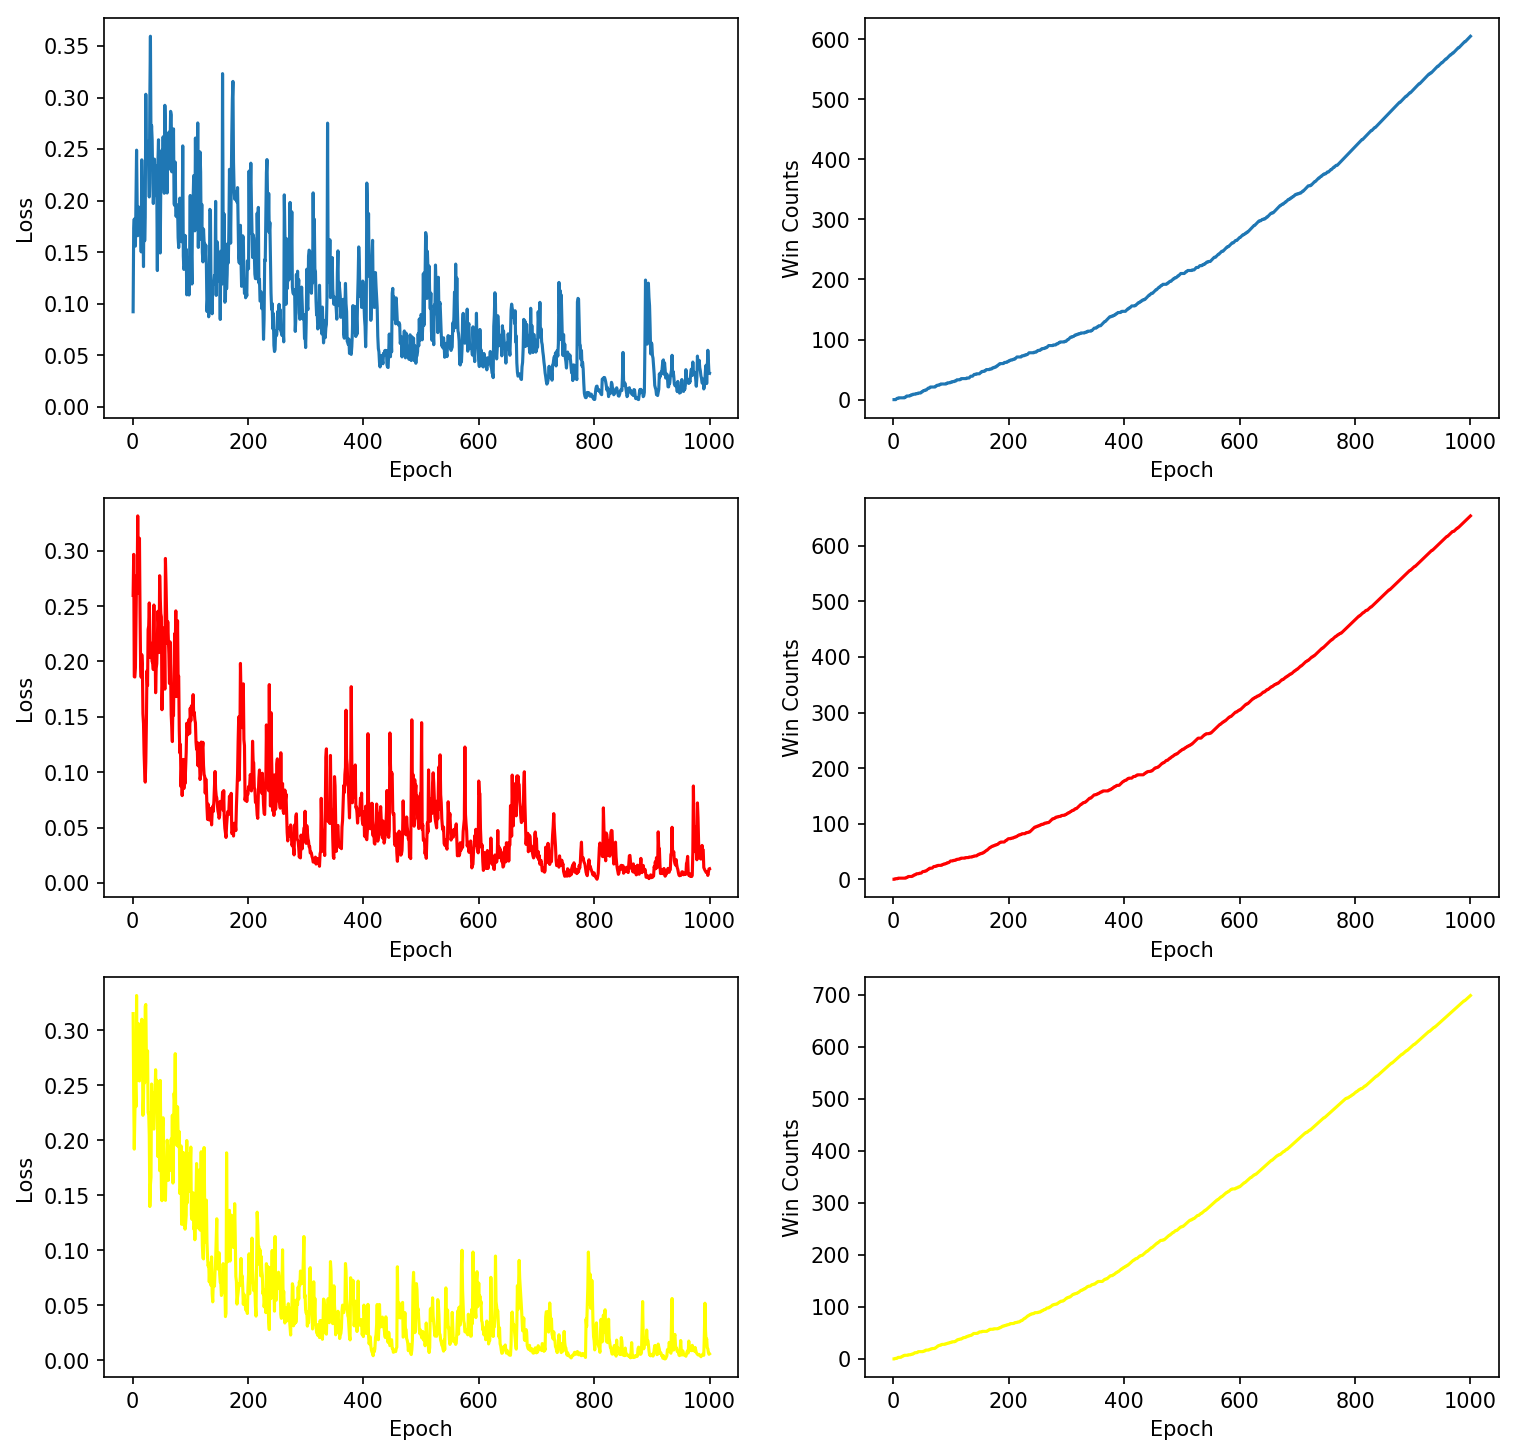

In [70]:
plt.figure(figsize = (12,12), dpi=150)
plt.subplot(3,2,1)
plt.plot(range(1,epoch+1), Loss1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(3,2,2)
plt.plot(range(1,epoch+1), Win_cnt1)
plt.xlabel('Epoch')
plt.ylabel('Win Counts')

plt.subplot(3,2,3)
plt.plot(range(1,epoch+1), Loss2, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(3,2,4)
plt.plot(range(1,epoch+1), Win_cnt2, 'r')
plt.xlabel('Epoch')
plt.ylabel('Win Counts')

plt.subplot(3,2,5)
plt.plot(range(1,epoch+1), Loss3, 'yellow')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(3,2,6)
plt.plot(range(1,epoch+1), Win_cnt3, 'yellow')
plt.xlabel('Epoch')
plt.ylabel('Win Counts')


plt.show()

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json

%matplotlib

grid_size = 10

model3.load_weights("model3.h5")
model3.compile("sgd", "mse")

# Define environment, game

c = 0
plt.ion() ## Note this correction
fig=plt.figure()
for e in range(10):
    loss = 0.
    n = np.random.randint(0, grid_size-1, size=1)
    m = np.random.randint(1, grid_size-2, size=1)
    state = np.asarray([0, n, m])[np.newaxis]
    game_over = False
    # get initial input
    
    im_size = (grid_size,)*2
    state = state[0]
    canvas = np.zeros(im_size)
    canvas[state[0], state[1]] = 1  # draw fruit
    canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
    canvas=canvas.transpose()
    input_t = canvas.reshape((1, -1))

    plt.imshow(input_t.reshape((grid_size,)*2),
               interpolation='none', cmap='gray')
    plt.savefig("%03d.png" % c)
    c += 1
    while not game_over:
        input_tm1 = input_t

        # get next action
        q = model3.predict(input_tm1)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        state, input_t, reward, game_over = Action(action, state)

        plt.imshow(input_t.reshape((grid_size,)*2),
                   interpolation='none', cmap='gray')
        plt.pause(0.00001)
        plt.savefig("%03d.png" % c)
        c += 1

Using matplotlib backend: Qt5Agg


/home/arash/anaconda2/lib/python2.7/site-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


KeyboardInterrupt: 